In [2]:
import pandas as pd

# Load the data
data = pd.read_csv('Dr Yahya.csv',low_memory=False)

# Show the first few rows
print(data.head())

# Basic information about the dataset
print(data.info())

   dr                             survey_id     region       district  \
0   1  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   
1   2  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   
2   3  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   
3   4  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   
4   5  SOM_2000_08_admin2_dhuusamarreeb_idp  Galgaduud  Dhuusamarreeb   

          admin0  pcode   n  n_u5  n_died  n_died_u5  ...  \
0  South-Central   1901   4     0       0          0  ...   
1  South-Central   1901   7     2       0          0  ...   
2  South-Central   1901   6     1       0          0  ...   
3  South-Central   1901   6     0       0          0  ...   
4  South-Central   1901  17     1       0          0  ...   

   tot_goat_cereal_smooth_lag4_cat  tot_wage_cereal_smooth_cat  \
0                         <200,000            20,000 to 29,999   
1                         <200,000            20,000 to 29,999

/tmp/ipykernel_7250/2818116104.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['survey_type'] = filtered_data['district']  # Replace with the correct logic to determine survey type


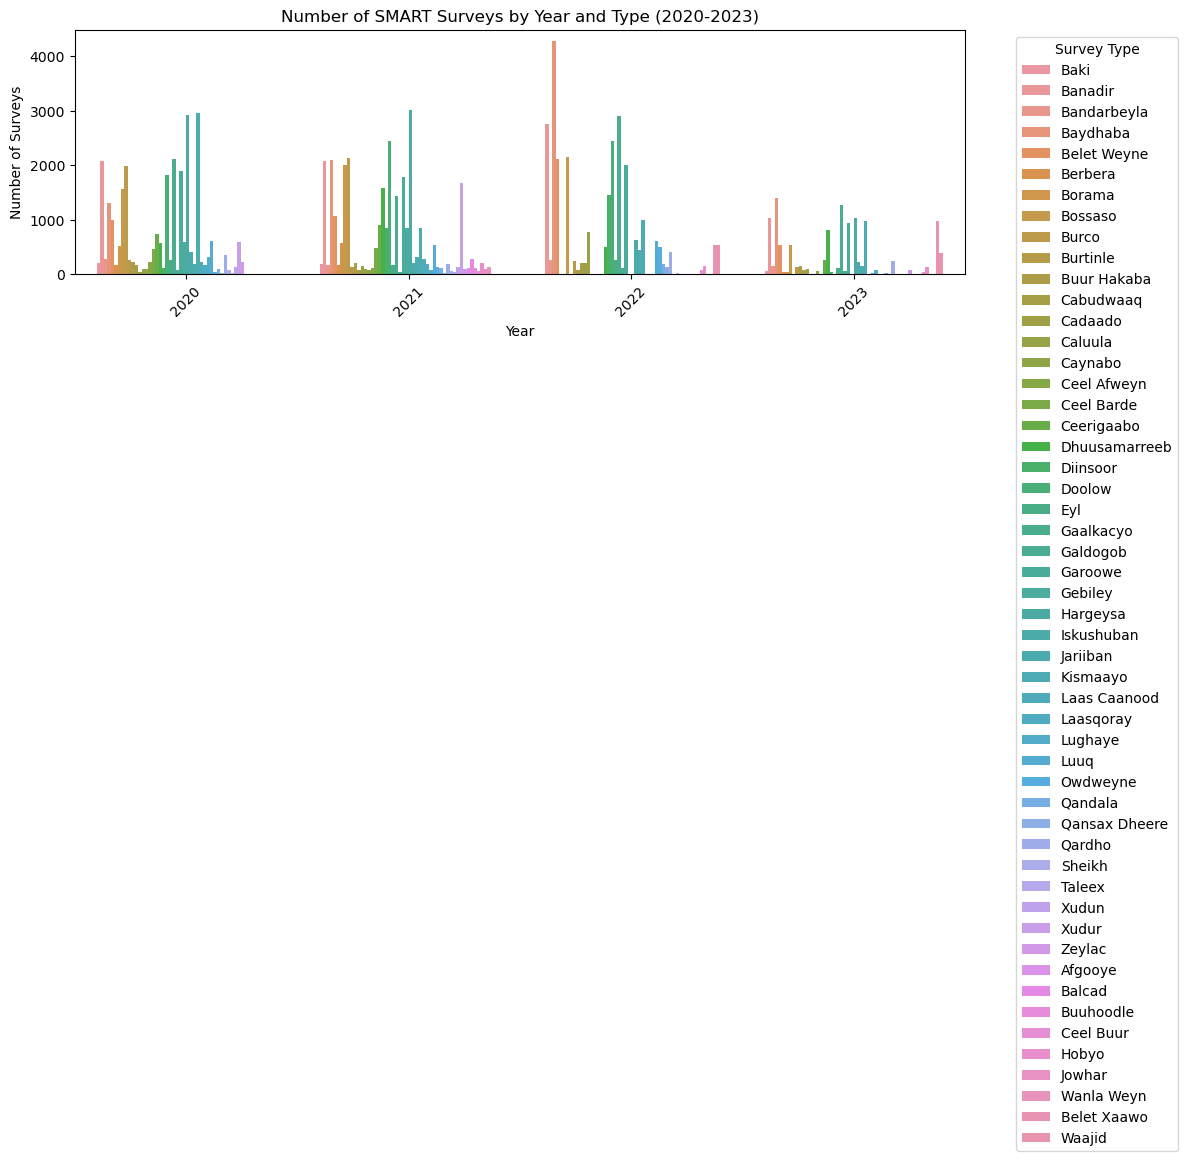

In [5]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
# Parse years and filter for 2020 to 2023
data['parsed_year'] = data['survey_id'].apply(lambda x: re.findall(r'\d{4}', x))
data['parsed_year'] = data['parsed_year'].apply(lambda x: x[0] if x else 'Unknown')



filtered_data = data[data['parsed_year'].isin(['2020', '2021', '2022', '2023'])]

# Assuming survey types are in a column named 'survey_type', if not we need to extract that information as well.
# For now, we will create a dummy 'survey_type' column to proceed with the plotting.
filtered_data['survey_type'] = filtered_data['district']  # Replace with the correct logic to determine survey type

# Aggregate filtered data for plotting
filtered_survey_count = filtered_data.groupby(['parsed_year', 'survey_type']).size().reset_index(name='counts')

# Plotting the filtered data
plt.figure(figsize=(12, 8))
sns.barplot(x='parsed_year', y='counts', hue='survey_type', data=filtered_survey_count)
plt.title('Number of SMART Surveys by Year and Type (2020-2023)')
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Surveys')
plt.legend(title='Survey Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save and display the plot
plt.savefig('filtered_smart_surveys_by_year.png')
plt.show()

filtered_data = data

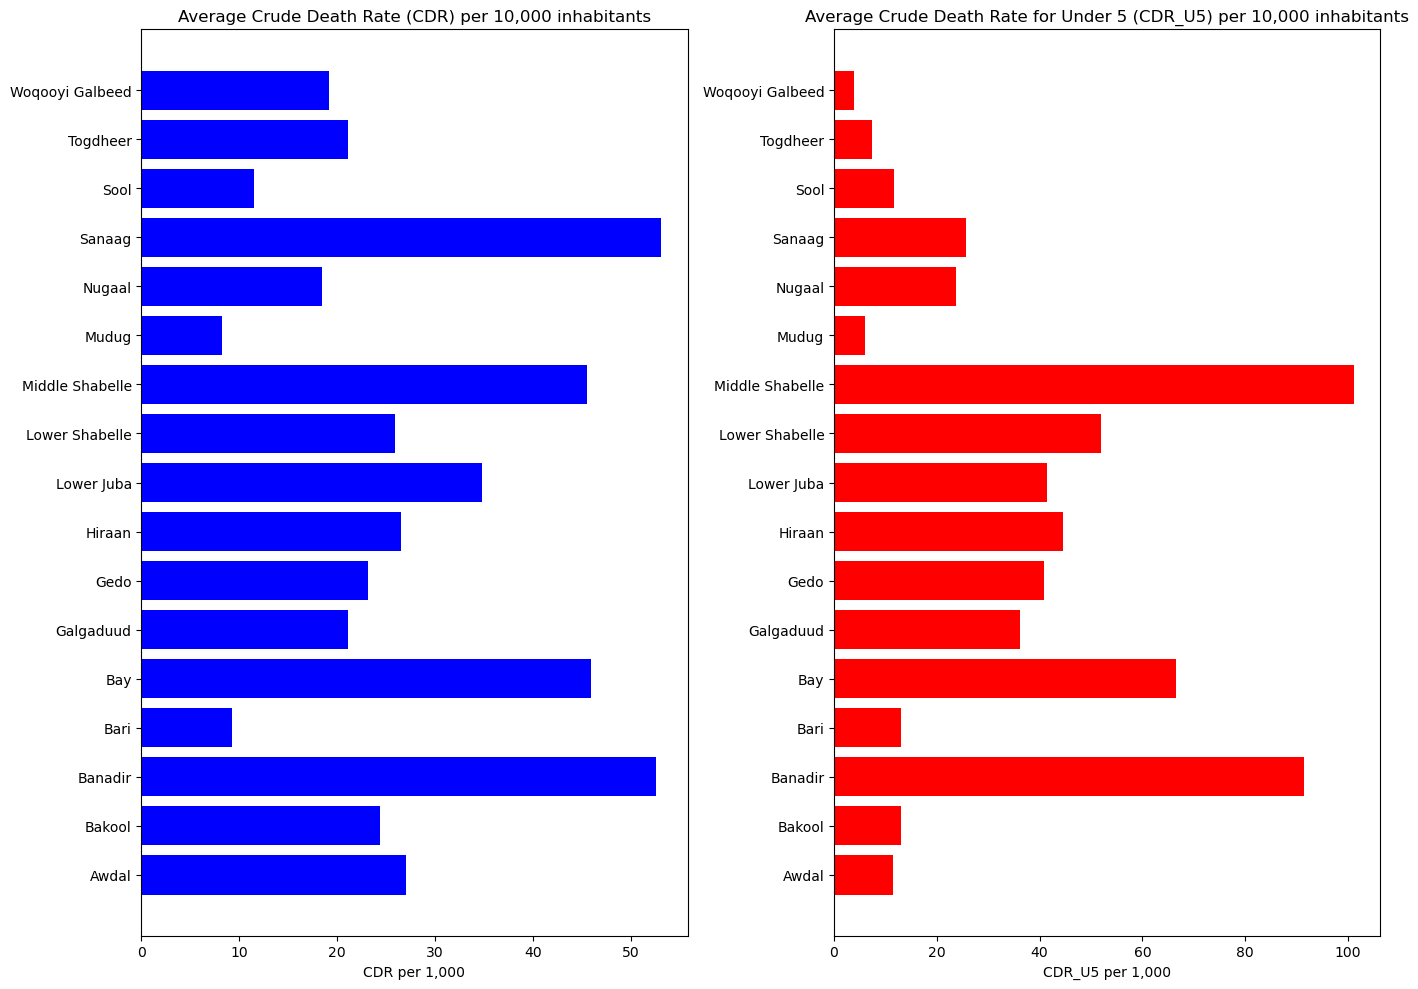

In [6]:
# Calculate CDR and CDR under 5 per region
data['CDR'] = (data['n_died'] / data['n']) * 10000
data['CDR_U5'] = (data['n_died_u5'] / data['n_u5']) * 10000

# Replace infinities or NaN values with 0, which can occur if n or n_u5 is zero
data['CDR'].replace([float('inf'), float('nan')], 0, inplace=True)
data['CDR_U5'].replace([float('inf'), float('nan')], 0, inplace=True)

# Group by region and calculate the average CDR and CDR_U5
regional_cdr = data.groupby('region')[['CDR', 'CDR_U5']].mean().reset_index()

regional_cdr


import matplotlib.pyplot as plt


# Set the plot size
plt.figure(figsize=(14, 10))

# Create a horizontal bar chart for CDR
plt.subplot(1, 2, 1)
plt.barh(regional_cdr['region'], regional_cdr['CDR'], color='blue')
plt.title('Average Crude Death Rate (CDR) per 10,000 inhabitants')
plt.xlabel('CDR per 1,000')

# Create a horizontal bar chart for CDR_U5
plt.subplot(1, 2, 2)
plt.barh(regional_cdr['region'], regional_cdr['CDR_U5'], color='red')
plt.title('Average Crude Death Rate for Under 5 (CDR_U5) per 10,000 inhabitants')
plt.xlabel('CDR_U5 per 1,000')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('CDR and CDR u5 with regions.png')
plt.show()


In [17]:
#Convert 'date' from Excel serial date format to datetime
data['date'] = pd.to_datetime(data['date'], unit='D', origin='1899-12-30')

# Extract year and month from the date for grouping
data['year_month'] = data['date'].dt.to_period('M')

# Group by new year_month column to calculate average CDR, CDR_U5, and rainfall
monthly_data = data.groupby('year_month')[['CDR', 'CDR_U5', 'rainfall']].mean().reset_index()

# Display the transformed data
monthly_data.head(), monthly_data.tail()

ValueError: '0        2020-06-01
1        2020-06-01
2        2020-06-01
3        2020-06-01
4        2020-06-01
            ...    
105559   2021-02-01
105560   2021-02-01
105561   2021-02-01
105562   2021-02-01
105563   2021-02-01
Name: date, Length: 105564, dtype: datetime64[ns]' is not compatible with origin='1899-12-30'; it must be numeric with a unit specified

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Preparing the data for training
# We will predict CDR based on the available features
# For simplicity, let's assume we will use 'rainfall' and the month as features
data['month'] = data['date'].dt.month

# Select features and target
X = data[['rainfall', 'month']]
y = data['CDR']

# Check for missing values in the features
missing_values = X.isna().sum()

# Filling missing values with the mean of each column
X_filled = X.fillna(X.mean())

# Splitting the data into training and testing sets with the filled data
X_train_filled, X_test_filled, y_train_filled, y_test_filled = train_test_split(X_filled, y, test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Re-training the models with filled data
lr.fit(X_train_filled, y_train_filled)
dt.fit(X_train_filled, y_train_filled)
rf.fit(X_train_filled, y_train_filled)

# Making predictions
y_pred_lr_filled = lr.predict(X_test_filled)
y_pred_dt_filled = dt.predict(X_test_filled)
y_pred_rf_filled = rf.predict(X_test_filled)

# Calculate the Mean Squared Errors with filled data
mse_lr_filled = mean_squared_error(y_test_filled, y_pred_lr_filled)
mse_dt_filled = mean_squared_error(y_test_filled, y_pred_dt_filled)
mse_rf_filled = mean_squared_error(y_test_filled, y_pred_rf_filled)

# Calculate R² values for the models
r2_lr = r2_score(y_test_filled, y_pred_lr_filled)
r2_dt = r2_score(y_test_filled, y_pred_dt_filled)
r2_rf = r2_score(y_test_filled, y_pred_rf_filled)

# Calculate the variance of the CDR values in the dataset
variance_cdr = y.var()

{
    "missing_values": missing_values,
    "MSE": {
        "Linear Regression": mse_lr_filled,
        "Decision Tree": mse_dt_filled,
        "Random Forest": mse_rf_filled
    },
    "R2": {
        "Linear Regression": r2_lr,
        "Decision Tree": r2_dt,
        "Random Forest": r2_rf
    },
    "Variance of CDR": variance_cdr
}


{'missing_values': rainfall    816
 month         0
 dtype: int64,
 'MSE': {'Linear Regression': 51167.47327254956,
  'Decision Tree': 50892.498862498105,
  'Random Forest': 50889.55719654117},
 'R2': {'Linear Regression': 0.0002355073445076128,
  'Decision Tree': 0.0056082497133558284,
  'Random Forest': 0.005665727110321095},
 'Variance of CDR': 52639.264197601005}

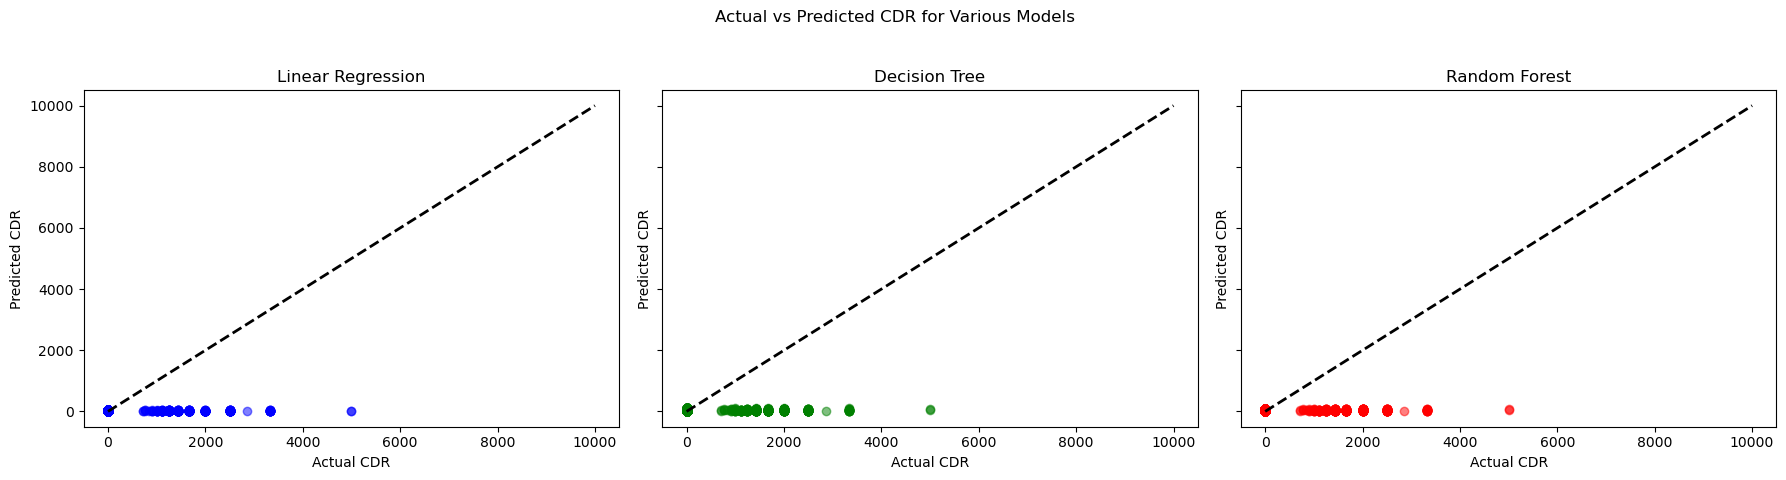

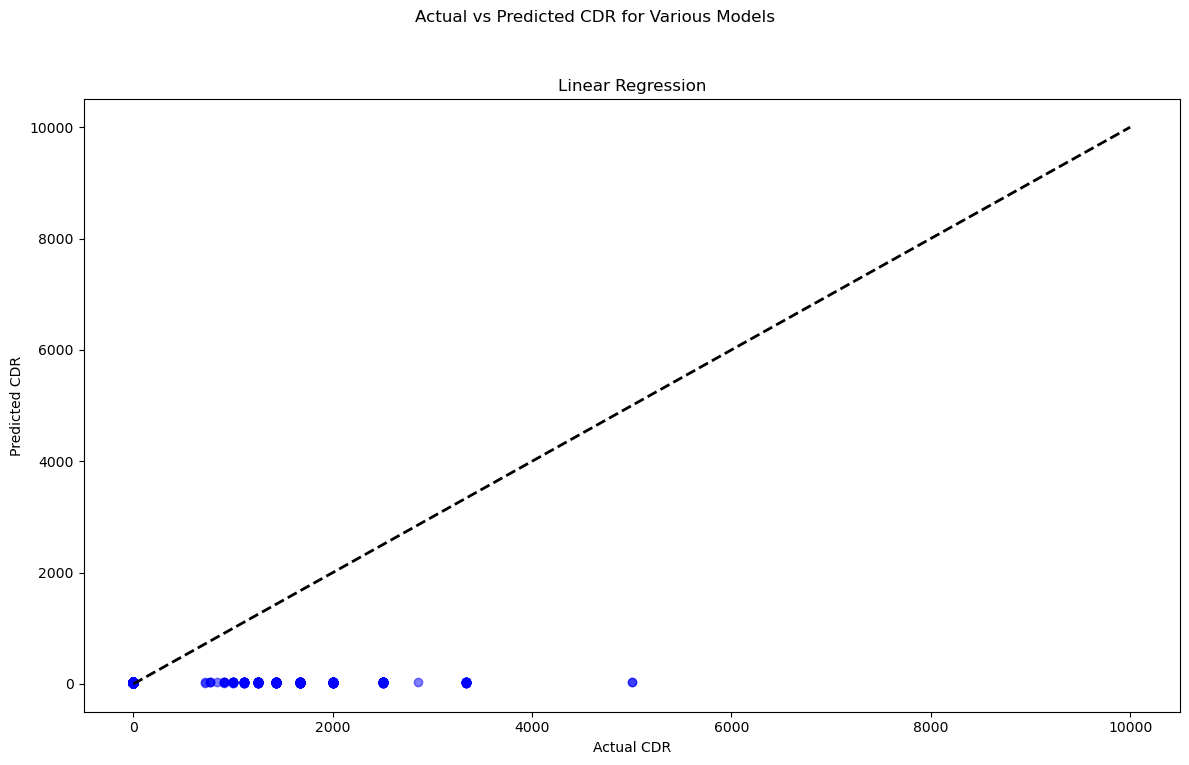

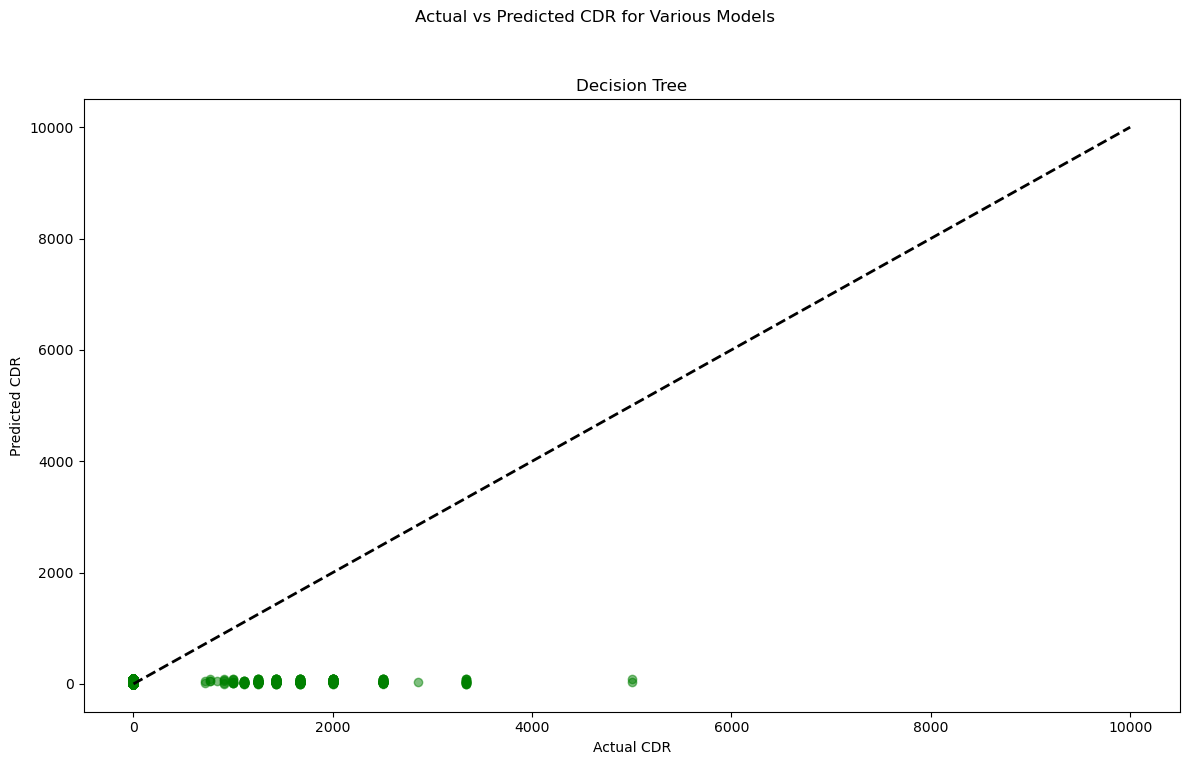

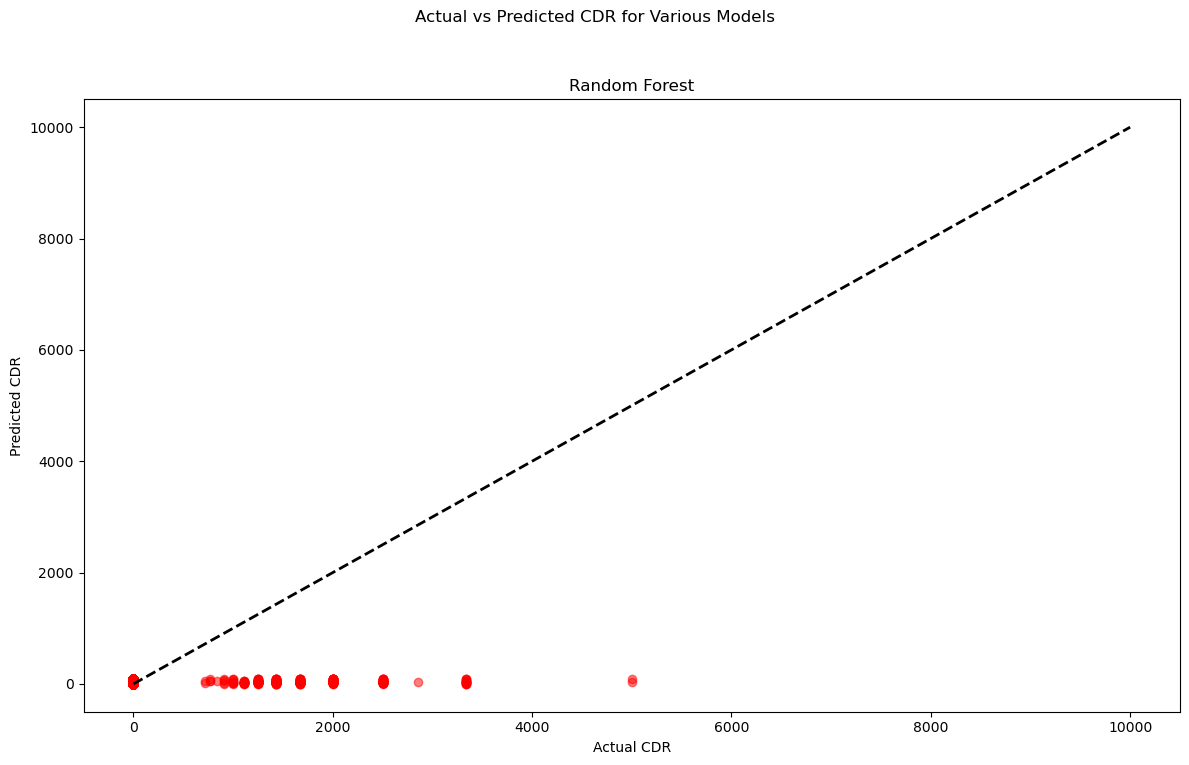

In [25]:
from sklearn.model_selection import cross_val_score

# Performing 5-fold cross-validation for each model and calculating the mean MSE and R² for each
cv_scores_lr_mse = cross_val_score(lr, X_filled, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_dt_mse = cross_val_score(dt, X_filled, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_rf_mse = cross_val_score(rf, X_filled, y, cv=5, scoring='neg_mean_squared_error')

cv_scores_lr_r2 = cross_val_score(lr, X_filled, y, cv=5, scoring='r2')
cv_scores_dt_r2 = cross_val_score(dt, X_filled, y, cv=5, scoring='r2')
cv_scores_rf_r2 = cross_val_score(rf, X_filled, y, cv=5, scoring='r2')

# Calculating the average scores across the folds
cv_results = {
    "Linear Regression": {"MSE": -cv_scores_lr_mse.mean(), "R²": cv_scores_lr_r2.mean()},
    "Decision Tree": {"MSE": -cv_scores_dt_mse.mean(), "R²": cv_scores_dt_r2.mean()},
    "Random Forest": {"MSE": -cv_scores_rf_mse.mean(), "R²": cv_scores_rf_r2.mean()}
}

cv_results



# Generating predictions for each model on the test set for visualization
y_pred_lr = lr.predict(X_test_filled)
y_pred_dt = dt.predict(X_test_filled)
y_pred_rf = rf.predict(X_test_filled)

# Plotting actual vs predicted values for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Linear Regression
axes[0].scatter(y_test_filled, y_pred_lr, alpha=0.5, color='blue')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Actual CDR')
axes[0].set_ylabel('Predicted CDR')

# Decision Tree
axes[1].scatter(y_test_filled, y_pred_dt, alpha=0.5, color='green')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[1].set_title('Decision Tree')
axes[1].set_xlabel('Actual CDR')
axes[1].set_ylabel('Predicted CDR')

# Random Forest
axes[2].scatter(y_test_filled, y_pred_rf, alpha=0.5, color='red')
axes[2].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[2].set_title('Random Forest')
axes[2].set_xlabel('Actual CDR')
axes[2].set_ylabel('Predicted CDR')

fig.suptitle('Actual vs Predicted CDR for Various Models')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('model_predictions.png')
plt.show()



y_pred_lr = lr.predict(X_test_filled)
y_pred_dt = dt.predict(X_test_filled)
y_pred_rf = rf.predict(X_test_filled)

# Plotting actual vs predicted values for all models
fig, axes = plt.subplots(figsize=(12, 8), sharey=True)

# Linear Regression
axes.scatter(y_test_filled, y_pred_lr, alpha=0.5, color='blue')
axes.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes.set_title('Linear Regression')
axes.set_xlabel('Actual CDR')
axes.set_ylabel('Predicted CDR')

# # Decision Tree
# axes[1].scatter(y_test_filled, y_pred_dt, alpha=0.5, color='green')
# axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
# axes[1].set_title('Decision Tree')
# axes[1].set_xlabel('Actual CDR')
# axes[1].set_ylabel('Predicted CDR')

# # Random Forest
# axes[2].scatter(y_test_filled, y_pred_rf, alpha=0.5, color='red')
# axes[2].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
# axes[2].set_title('Random Forest')
# axes[2].set_xlabel('Actual CDR')
# axes[2].set_ylabel('Predicted CDR')

fig.suptitle('Actual vs Predicted CDR for Various Models')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('linear_regresion_prediction vs actual.png')
plt.show()


y_pred_lr = lr.predict(X_test_filled)
y_pred_dt = dt.predict(X_test_filled)
y_pred_rf = rf.predict(X_test_filled)

# Plotting actual vs predicted values for all models
fig, axes = plt.subplots(1, figsize=(12, 8), sharey=True)

# # Linear Regression
# axes[0].scatter(y_test_filled, y_pred_lr, alpha=0.5, color='blue')
# axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
# axes[0].set_title('Linear Regression')
# axes[0].set_xlabel('Actual CDR')
# axes[0].set_ylabel('Predicted CDR')

# Decision Tree
axes.scatter(y_test_filled, y_pred_dt, alpha=0.5, color='green')
axes.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes.set_title('Decision Tree')
axes.set_xlabel('Actual CDR')
axes.set_ylabel('Predicted CDR')

# Random Forest
# axes[2].scatter(y_test_filled, y_pred_rf, alpha=0.5, color='red')
# axes[2].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
# axes[2].set_title('Random Forest')
# axes[2].set_xlabel('Actual CDR')
# axes[2].set_ylabel('Predicted CDR')

fig.suptitle('Actual vs Predicted CDR for Various Models')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Decision_tree prediction vs actual.png')
plt.show()





# Plotting actual vs predicted values for all models
fig, axes = plt.subplots(1, figsize=(12, 8), sharey=True)

# # Linear Regression
# axes[0].scatter(y_test_filled, y_pred_lr, alpha=0.5, color='blue')
# axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
# axes[0].set_title('Linear Regression')
# axes[0].set_xlabel('Actual CDR')
# axes[0].set_ylabel('Predicted CDR')

# # Decision Tree
# axes.scatter(y_test_filled, y_pred_dt, alpha=0.5, color='green')
# axes.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
# axes.set_title('Decision Tree')
# axes.set_xlabel('Actual CDR')
# axes.set_ylabel('Predicted CDR')

# Random Forest
axes.scatter(y_test_filled, y_pred_rf, alpha=0.5, color='red')
axes.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes.set_title('Random Forest')
axes.set_xlabel('Actual CDR')
axes.set_ylabel('Predicted CDR')

fig.suptitle('Actual vs Predicted CDR for Various Models')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Random_forest prediction vs actual.png')
plt.show()

In [12]:



# Determine the last month in the dataset
last_date = data['date'].max()

# Calculate the months for the next three months
import calendar
from dateutil.relativedelta import relativedelta

next_month = last_date + relativedelta(months=1)
second_month = last_date + relativedelta(months=2)
third_month = last_date + relativedelta(months=3)

# Assuming average rainfall for simplicity
# Let's use the mean rainfall for each corresponding month from the past data as an assumption for future rainfall
rainfall_next_month = data[data['date'].dt.month == next_month.month]['rainfall'].mean()
rainfall_second_month = data[data['date'].dt.month == second_month.month]['rainfall'].mean()
rainfall_third_month = data[data['date'].dt.month == third_month.month]['rainfall'].mean()

# Prepare the feature set for prediction
future_months = pd.DataFrame({
    'rainfall': [rainfall_next_month, rainfall_second_month, rainfall_third_month],
    'month': [next_month.month, second_month.month, third_month.month]
})

future_months




,rainfall,month
0,37.193784,7
1,NaN,8
2,19.397852,9


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Preparing the target for CDR_U5 predictions
y_u5 = data['CDR_U5']

# Splitting the data for CDR_U5
X_train_u5, X_test_u5, y_train_u5, y_test_u5 = train_test_split(X_filled, y_u5, test_size=0.2, random_state=42)

# Initialize a new Random Forest model for CDR_U5
rf_u5 = RandomForestRegressor(random_state=42)

# Training the model for CDR_U5
rf_u5.fit(X_train_u5, y_train_u5)

# Impute missing values in future_months before prediction
imputer = SimpleImputer(strategy='median')
future_months_filled = imputer.fit_transform(future_months)
future_months_filled = pd.DataFrame(future_months_filled, columns=future_months.columns)

# Making predictions for the next three months using the trained Random Forest model for CDR_U5
predictions_u5_next_three_months = rf_u5.predict(future_months_filled)

# Create a DataFrame to store predicted values
predicted_cdr = pd.DataFrame({
    'Month': ['July', 'August', 'September'],
    'Predicted CDR_U5': predictions_u5_next_three_months
})

# Fill the missing rainfall value for August by averaging July and September
future_months.loc[1, 'rainfall'] = (future_months.loc[0, 'rainfall'] + future_months.loc[2, 'rainfall']) / 2

# Re-impute after filling specific missing values manually
future_months_filled = imputer.transform(future_months)
future_months_filled = pd.DataFrame(future_months_filled, columns=future_months.columns)

# Making predictions for the next three months using the trained Random Forest model
predictions_next_three_months = rf.predict(future_months_filled)

# Add CDR predictions to the DataFrame
predicted_cdr['Predicted CDR'] = predictions_next_three_months

predicted_cdr


,Month,Predicted CDR_U5,Predicted CDR
0,July,34.872197,21.751670
1,August,80.070208,44.626728
2,September,77.046111,39.644240


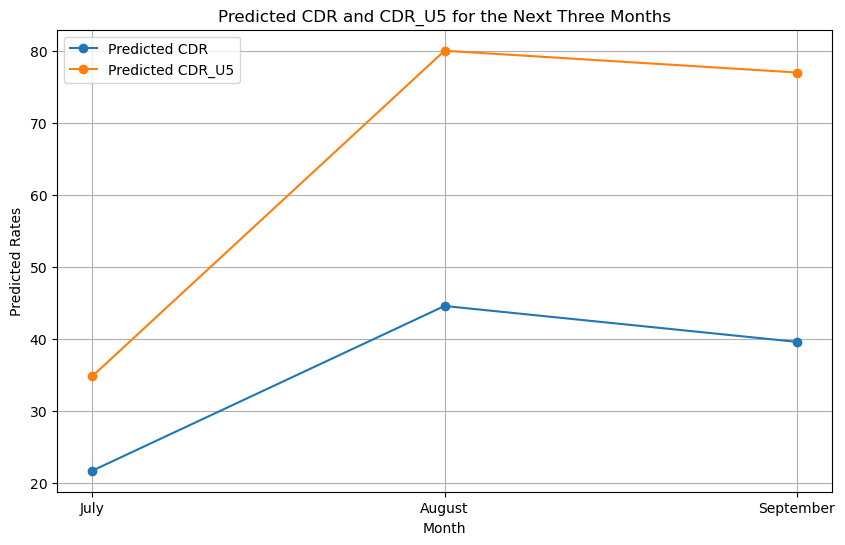

In [14]:
# Plotting the predictions
plt.figure(figsize=(10, 6))
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR'], label='Predicted CDR', marker='o')
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_U5'], label='Predicted CDR_U5', marker='o')
plt.title('Predicted CDR and CDR_U5 for the Next Three Months')
plt.xlabel('Month')
plt.ylabel('Predicted Rates')
plt.grid(True)
plt.legend()
plt.savefig('futere_prediction.png')
plt.show()

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'data' DataFrame is already defined and preprocessed
data['month'] = data['date'].dt.month

# Select features and target
X = data[['rainfall', 'month']]
y = data['CDR']

# Check for missing values in the features
missing_values = X.isna().sum()

# Filling missing values with the mean of each column
X_filled = X.fillna(X.mean())

# Splitting the data into training and testing sets with the filled data
X_train_filled, X_test_filled, y_train_filled, y_test_filled = train_test_split(X_filled, y, test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Re-training the models with filled data
lr.fit(X_train_filled, y_train_filled)
dt.fit(X_train_filled, y_train_filled)
rf.fit(X_train_filled, y_train_filled)

# Making predictions
y_pred_lr_filled = lr.predict(X_test_filled)
y_pred_dt_filled = dt.predict(X_test_filled)
y_pred_rf_filled = rf.predict(X_test_filled)

# Calculate the Mean Squared Errors with filled data
mse_lr_filled = mean_squared_error(y_test_filled, y_pred_lr_filled)
mse_dt_filled = mean_squared_error(y_test_filled, y_pred_dt_filled)
mse_rf_filled = mean_squared_error(y_test_filled, y_pred_rf_filled)

# Calculate R² values for the models
r2_lr = r2_score(y_test_filled, y_pred_lr_filled)
r2_dt = r2_score(y_test_filled, y_pred_dt_filled)
r2_rf = r2_score(y_test_filled, y_pred_rf_filled)

# Calculate the variance of the CDR values in the dataset
variance_cdr = y.var()

# Prepare the target for CDR_U5 predictions
y_u5 = data['CDR_U5']

# Splitting the data for CDR_U5
X_train_u5, X_test_u5, y_train_u5, y_test_u5 = train_test_split(X_filled, y_u5, test_size=0.2, random_state=42)

# Initialize a new Random Forest model for CDR_U5
rf_u5 = RandomForestRegressor(random_state=42)

# Training the model for CDR_U5
rf_u5.fit(X_train_u5, y_train_u5)

# Impute missing values in future_months before prediction
imputer = SimpleImputer(strategy='median')
future_months_filled = imputer.fit_transform(future_months)
future_months_filled = pd.DataFrame(future_months_filled, columns=future_months.columns)

# Making predictions for the next three months using the trained Random Forest model for CDR_U5
predictions_u5_next_three_months = rf_u5.predict(future_months_filled)

# Fill the missing rainfall value for August by averaging July and September
future_months.loc[1, 'rainfall'] = (future_months.loc[0, 'rainfall'] + future_months.loc[2, 'rainfall']) / 2

# Re-impute after filling specific missing values manually
future_months_filled = imputer.transform(future_months)
future_months_filled = pd.DataFrame(future_months_filled, columns=future_months.columns)

# Making predictions for the next three months using all three trained models
predictions_lr_next_three_months = lr.predict(future_months_filled)
predictions_dt_next_three_months = dt.predict(future_months_filled)
predictions_rf_next_three_months = rf.predict(future_months_filled)

# Create a DataFrame to store predicted values
predicted_cdr = pd.DataFrame({
    'Month': ['July', 'August', 'September'],
    'Predicted CDR_U5': predictions_u5_next_three_months,
    'Predicted CDR_LR': predictions_lr_next_three_months,
    'Predicted CDR_DT': predictions_dt_next_three_months,
    'Predicted CDR_RF': predictions_rf_next_three_months
})

{
    "missing_values": missing_values,
    "MSE": {
        "Linear Regression": mse_lr_filled,
        "Decision Tree": mse_dt_filled,
        "Random Forest": mse_rf_filled
    },
    "R2": {
        "Linear Regression": r2_lr,
        "Decision Tree": r2_dt,
        "Random Forest": r2_rf
    },
    "Variance of CDR": variance_cdr,
    "Predicted CDR": predicted_cdr
}


{'missing_values': rainfall    816
 month         0
 dtype: int64,
 'MSE': {'Linear Regression': 51167.47327254956,
  'Decision Tree': 50892.498862498105,
  'Random Forest': 50889.55719654117},
 'R2': {'Linear Regression': 0.0002355073445076128,
  'Decision Tree': 0.0056082497133558284,
  'Random Forest': 0.005665727110321095},
 'Variance of CDR': 52639.264197601005,
 'Predicted CDR':        Month  Predicted CDR_U5  Predicted CDR_LR  Predicted CDR_DT  \
 0       July         34.872197         28.534420         22.399358   
 1     August         80.070208         26.803838         57.331557   
 2  September         77.046111         25.073255         44.956254   
 
    Predicted CDR_RF  
 0         21.751670  
 1         44.626728  
 2         39.644240  }

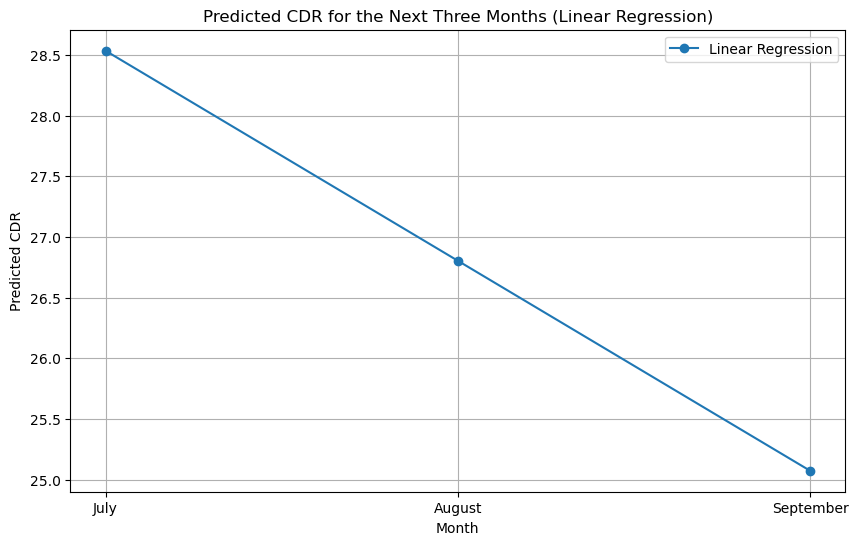

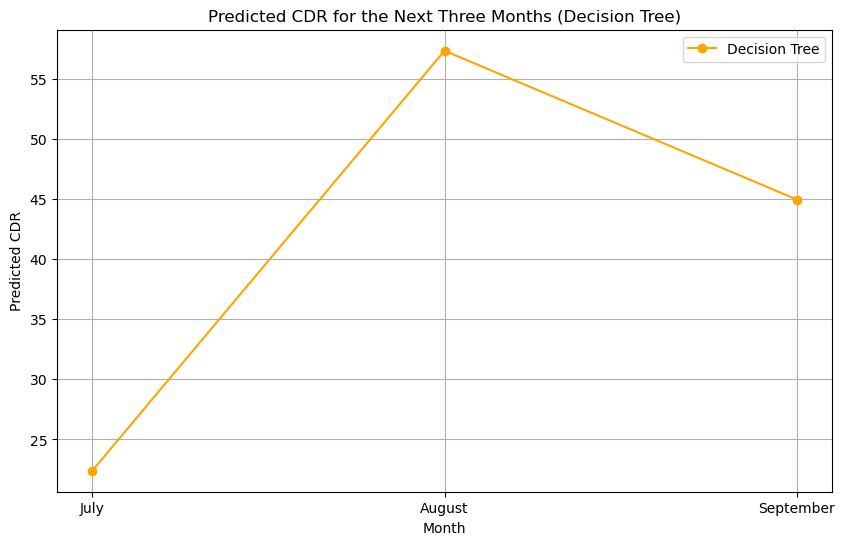

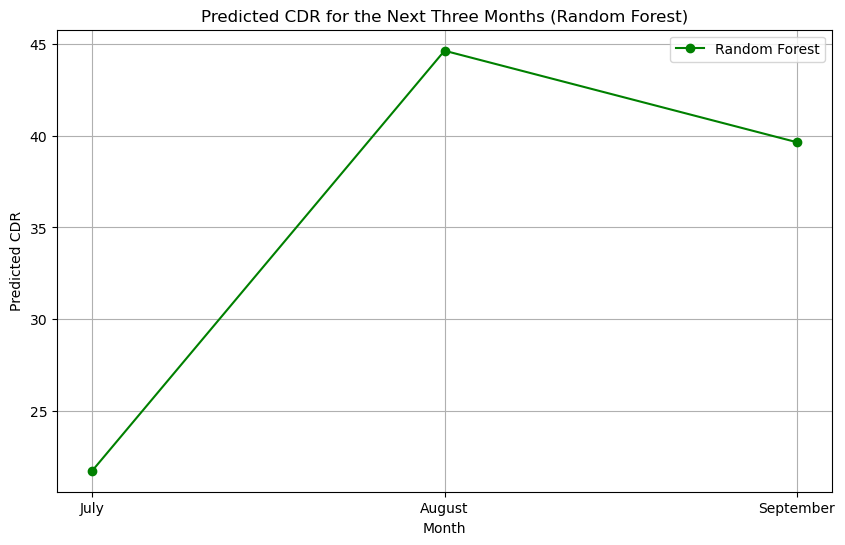

ModuleNotFoundError: No module named 'ace_tools'

In [16]:
import matplotlib.pyplot as plt

# Plot predictions for Linear Regression
plt.figure(figsize=(10, 6))
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_LR'], marker='o', label='Linear Regression')
plt.title('Predicted CDR for the Next Three Months (Linear Regression)')
plt.xlabel('Month')
plt.ylabel('Predicted CDR')
plt.grid(True)
plt.legend()
plt.show()

# Plot predictions for Decision Tree
plt.figure(figsize=(10, 6))
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_DT'], marker='o', color='orange', label='Decision Tree')
plt.title('Predicted CDR for the Next Three Months (Decision Tree)')
plt.xlabel('Month')
plt.ylabel('Predicted CDR')
plt.grid(True)
plt.legend()
plt.show()

# Plot predictions for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_RF'], marker='o', color='green', label='Random Forest')
plt.title('Predicted CDR for the Next Three Months (Random Forest)')
plt.xlabel('Month')
plt.ylabel('Predicted CDR')
plt.grid(True)
plt.legend()
plt.show()

# Display the DataFrame with predictions
import ace_tools as tools; tools.display_dataframe_to_user(name="Predicted CDR for the Next Three Months", dataframe=predicted_cdr)


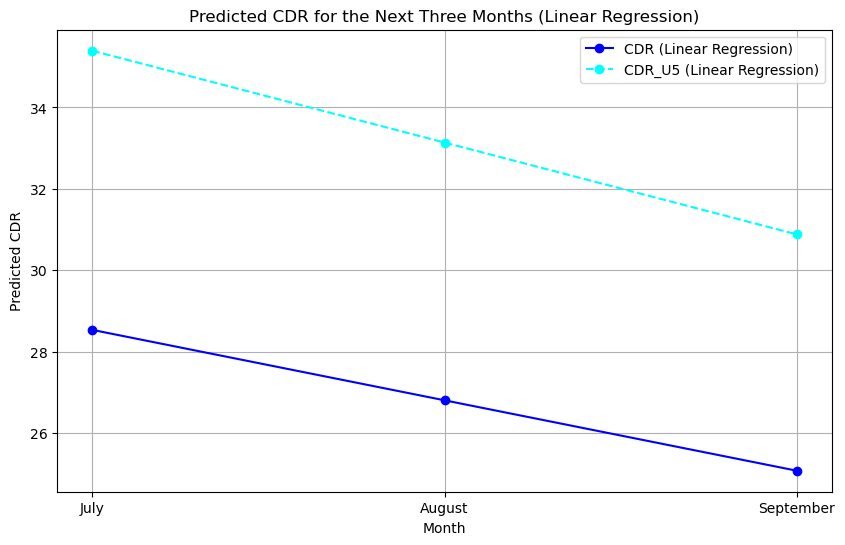

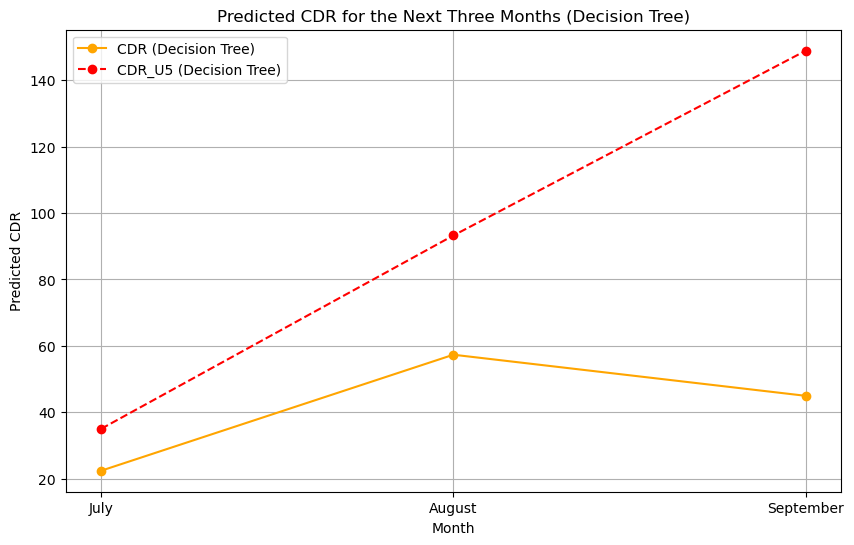

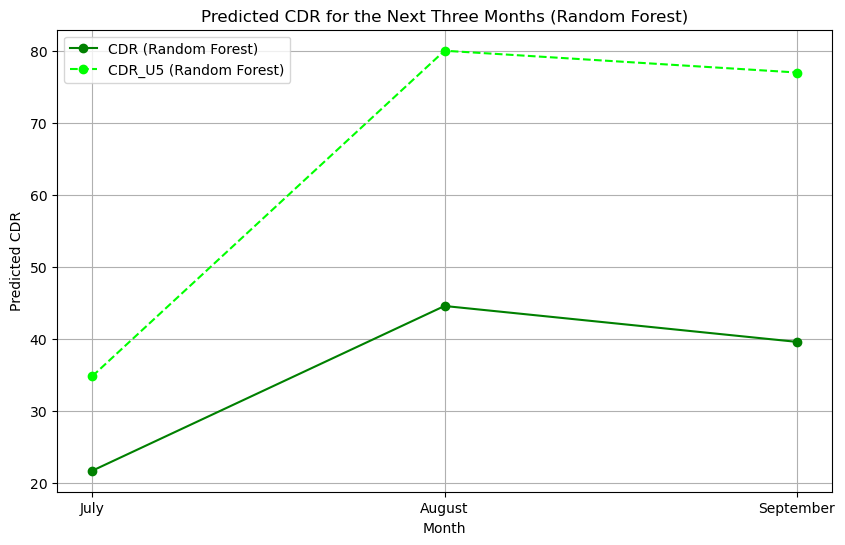

{'missing_values': rainfall    816
 month         0
 dtype: int64,
 'MSE': {'Linear Regression (CDR)': 51167.47327254956,
  'Decision Tree (CDR)': 50892.498862498105,
  'Random Forest (CDR)': 50889.55719654117,
  'Linear Regression (CDR_U5)': 206220.55710776063,
  'Decision Tree (CDR_U5)': 205616.38496097366,
  'Random Forest (CDR_U5)': 205612.4618681781},
 'R2': {'Linear Regression (CDR)': 0.0002355073445076128,
  'Decision Tree (CDR)': 0.0056082497133558284,
  'Random Forest (CDR)': 0.005665727110321095,
  'Linear Regression (CDR_U5)': 0.00012861347285519908,
  'Decision Tree (CDR_U5)': 0.0030579743987559915,
  'Random Forest (CDR_U5)': 0.0030769957237295475},
 'Variance of CDR': 52639.264197601005}

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'data' DataFrame is already defined and preprocessed
data['month'] = data['date'].dt.month

# Select features and target
X = data[['rainfall', 'month']]
y = data['CDR']
y_u5 = data['CDR_U5']

# Check for missing values in the features
missing_values = X.isna().sum()

# Filling missing values with the mean of each column
X_filled = X.fillna(X.mean())

# Splitting the data into training and testing sets with the filled data
X_train_filled, X_test_filled, y_train_filled, y_test_filled = train_test_split(X_filled, y, test_size=0.2, random_state=42)
X_train_u5, X_test_u5, y_train_u5, y_test_u5 = train_test_split(X_filled, y_u5, test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Training the models for CDR
lr.fit(X_train_filled, y_train_filled)
dt.fit(X_train_filled, y_train_filled)
rf.fit(X_train_filled, y_train_filled)

# Training the models for CDR_U5
lr_u5 = LinearRegression()
dt_u5 = DecisionTreeRegressor(random_state=42)
rf_u5 = RandomForestRegressor(random_state=42)

lr_u5.fit(X_train_u5, y_train_u5)
dt_u5.fit(X_train_u5, y_train_u5)
rf_u5.fit(X_train_u5, y_train_u5)

# Making predictions for CDR
y_pred_lr_filled = lr.predict(X_test_filled)
y_pred_dt_filled = dt.predict(X_test_filled)
y_pred_rf_filled = rf.predict(X_test_filled)

# Making predictions for CDR_U5
y_pred_lr_u5_filled = lr_u5.predict(X_test_u5)
y_pred_dt_u5_filled = dt_u5.predict(X_test_u5)
y_pred_rf_u5_filled = rf_u5.predict(X_test_u5)

# Calculate the Mean Squared Errors for CDR
mse_lr_filled = mean_squared_error(y_test_filled, y_pred_lr_filled)
mse_dt_filled = mean_squared_error(y_test_filled, y_pred_dt_filled)
mse_rf_filled = mean_squared_error(y_test_filled, y_pred_rf_filled)

# Calculate the Mean Squared Errors for CDR_U5
mse_lr_u5_filled = mean_squared_error(y_test_u5, y_pred_lr_u5_filled)
mse_dt_u5_filled = mean_squared_error(y_test_u5, y_pred_dt_u5_filled)
mse_rf_u5_filled = mean_squared_error(y_test_u5, y_pred_rf_u5_filled)

# Calculate R² values for the models for CDR
r2_lr = r2_score(y_test_filled, y_pred_lr_filled)
r2_dt = r2_score(y_test_filled, y_pred_dt_filled)
r2_rf = r2_score(y_test_filled, y_pred_rf_filled)

# Calculate R² values for the models for CDR_U5
r2_lr_u5 = r2_score(y_test_u5, y_pred_lr_u5_filled)
r2_dt_u5 = r2_score(y_test_u5, y_pred_dt_u5_filled)
r2_rf_u5 = r2_score(y_test_u5, y_pred_rf_u5_filled)

# Impute missing values in future_months before prediction
imputer = SimpleImputer(strategy='median')
future_months_filled = imputer.fit_transform(future_months)
future_months_filled = pd.DataFrame(future_months_filled, columns=future_months.columns)

# Making predictions for the next three months using all three trained models for CDR
predictions_lr_next_three_months = lr.predict(future_months_filled)
predictions_dt_next_three_months = dt.predict(future_months_filled)
predictions_rf_next_three_months = rf.predict(future_months_filled)

# Making predictions for the next three months using all three trained models for CDR_U5
predictions_lr_u5_next_three_months = lr_u5.predict(future_months_filled)
predictions_dt_u5_next_three_months = dt_u5.predict(future_months_filled)
predictions_rf_u5_next_three_months = rf_u5.predict(future_months_filled)

# Create a DataFrame to store predicted values
predicted_cdr = pd.DataFrame({
    'Month': ['July', 'August', 'September'],
    'Predicted CDR_LR': predictions_lr_next_three_months,
    'Predicted CDR_DT': predictions_dt_next_three_months,
    'Predicted CDR_RF': predictions_rf_next_three_months,
    'Predicted CDR_U5_LR': predictions_lr_u5_next_three_months,
    'Predicted CDR_U5_DT': predictions_dt_u5_next_three_months,
    'Predicted CDR_U5_RF': predictions_rf_u5_next_three_months
})

# Plot predictions for Linear Regression
plt.figure(figsize=(10, 6))
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_LR'], marker='o', label='CDR (Linear Regression)', color='blue')
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_U5_LR'], marker='o', linestyle='--', label='CDR_U5 (Linear Regression)', color='cyan')
plt.title('Predicted CDR for the Next Three Months (Linear Regression)')
plt.xlabel('Month')
plt.ylabel('Predicted CDR')
plt.grid(True)
plt.legend()
plt.savefig('Predicted_CDR_for_he_Next_Three_Months_(Linear Regression).png')
plt.show()

# Plot predictions for Decision Tree
plt.figure(figsize=(10, 6))
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_DT'], marker='o', color='orange', label='CDR (Decision Tree)')
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_U5_DT'], marker='o', linestyle='--', color='red', label='CDR_U5 (Decision Tree)')
plt.title('Predicted CDR for the Next Three Months (Decision Tree)')
plt.xlabel('Month')
plt.ylabel('Predicted CDR')
plt.grid(True)
plt.legend()
plt.savefig('Predicted_CDR_for the Next Three Months (Decision Tree).png')
plt.show()

# Plot predictions for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_RF'], marker='o', color='green', label='CDR (Random Forest)')
plt.plot(predicted_cdr['Month'], predicted_cdr['Predicted CDR_U5_RF'], marker='o', linestyle='--', color='lime', label='CDR_U5 (Random Forest)')
plt.title('Predicted CDR for the Next Three Months (Random Forest)')
plt.xlabel('Month')
plt.ylabel('Predicted CDR')
plt.grid(True)
plt.legend()
plt.savefig('Predicted CDR for the Next Three Months (Random Forest).png')
plt.show()

# Display the DataFrame with predictions
from sklearn.metrics import mean_squared_error, r2_score

{
    "missing_values": missing_values,
    "MSE": {
        "Linear Regression (CDR)": mse_lr_filled,
        "Decision Tree (CDR)": mse_dt_filled,
        "Random Forest (CDR)": mse_rf_filled,
        "Linear Regression (CDR_U5)": mse_lr_u5_filled,
        "Decision Tree (CDR_U5)": mse_dt_u5_filled,
        "Random Forest (CDR_U5)": mse_rf_u5_filled
    },
    "R2": {
        "Linear Regression (CDR)": r2_lr,
        "Decision Tree (CDR)": r2_dt,
        "Random Forest (CDR)": r2_rf,
        "Linear Regression (CDR_U5)": r2_lr_u5,
        "Decision Tree (CDR_U5)": r2_dt_u5,
        "Random Forest (CDR_U5)": r2_rf_u5
    },
    "Variance of CDR": variance_cdr
}


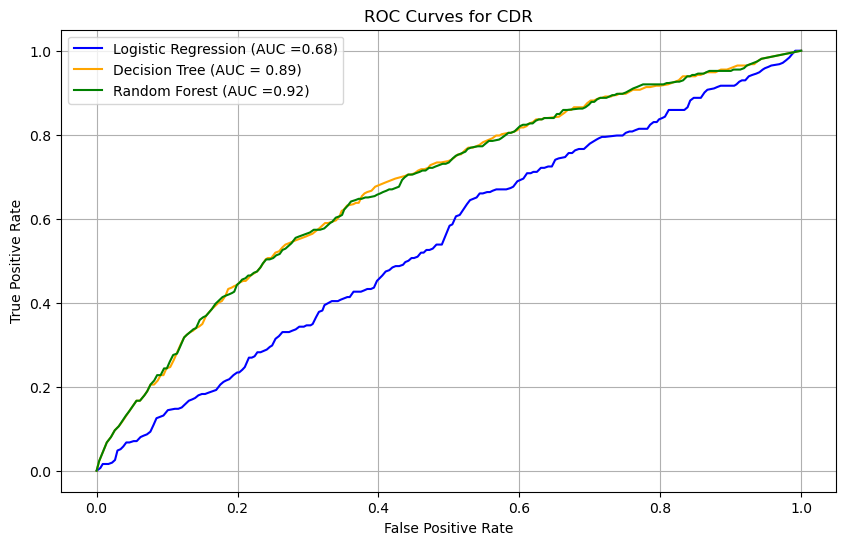

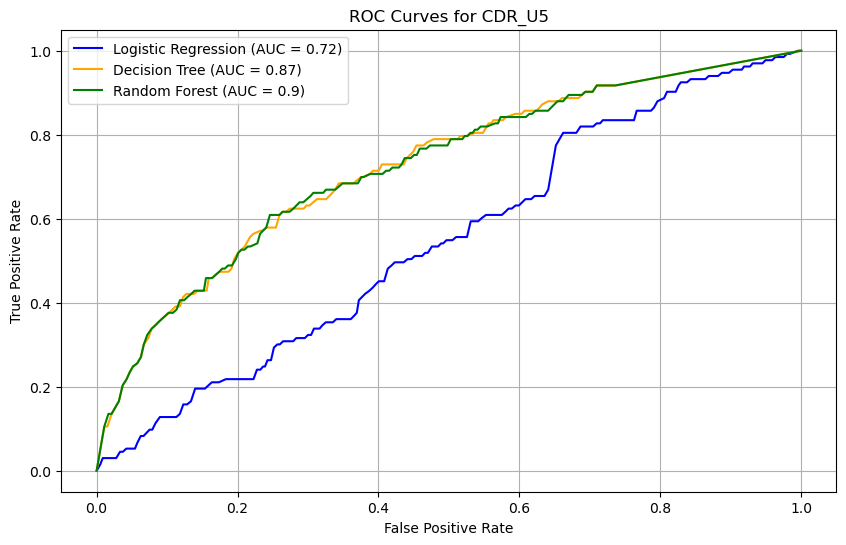

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming 'data' DataFrame is already defined and preprocessed
data['month'] = data['date'].dt.month

# Select features and target
X = data[['rainfall', 'month']]

# Define a threshold for binarizing the target variables
threshold_cdr = data['CDR'].median()
threshold_cdr_u5 = data['CDR_U5'].median()

# Binarize the target variables
y = data['CDR'].apply(lambda x: 1 if x > threshold_cdr else 0)
y_u5 = data['CDR_U5'].apply(lambda x: 1 if x > threshold_cdr_u5 else 0)

# Filling missing values with the mean of each column
X_filled = X.fillna(X.mean())

# Splitting the data into training and testing sets with the filled data
X_train_filled, X_test_filled, y_train_filled, y_test_filled = train_test_split(X_filled, y, test_size=0.2, random_state=42)
X_train_u5, X_test_u5, y_train_u5, y_test_u5 = train_test_split(X_filled, y_u5, test_size=0.2, random_state=42)

# Initialize the classifiers
lr = LogisticRegression()
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Training the classifiers for CDR
lr.fit(X_train_filled, y_train_filled)
dt.fit(X_train_filled, y_train_filled)
rf.fit(X_train_filled, y_train_filled)

# Training the classifiers for CDR_U5
lr_u5 = LogisticRegression()
dt_u5 = DecisionTreeClassifier(random_state=42)
rf_u5 = RandomForestClassifier(random_state=42)

lr_u5.fit(X_train_u5, y_train_u5)
dt_u5.fit(X_train_u5, y_train_u5)
rf_u5.fit(X_train_u5, y_train_u5)

# Making probability predictions for ROC curve
y_prob_lr_filled = lr.predict_proba(X_test_filled)[:, 1]
y_prob_dt_filled = dt.predict_proba(X_test_filled)[:, 1]
y_prob_rf_filled = rf.predict_proba(X_test_filled)[:, 1]

y_prob_lr_u5_filled = lr_u5.predict_proba(X_test_u5)[:, 1]
y_prob_dt_u5_filled = dt_u5.predict_proba(X_test_u5)[:, 1]
y_prob_rf_u5_filled = rf_u5.predict_proba(X_test_u5)[:, 1]

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test_filled, y_prob_lr_filled)
fpr_dt, tpr_dt, _ = roc_curve(y_test_filled, y_prob_dt_filled)
fpr_rf, tpr_rf, _ = roc_curve(y_test_filled, y_prob_rf_filled)

fpr_lr_u5, tpr_lr_u5, _ = roc_curve(y_test_u5, y_prob_lr_u5_filled)
fpr_dt_u5, tpr_dt_u5, _ = roc_curve(y_test_u5, y_prob_dt_u5_filled)
fpr_rf_u5, tpr_rf_u5, _ = roc_curve(y_test_u5, y_prob_rf_u5_filled)

# Plot ROC curves for CDR
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC ={ 0.68})', color='blue')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {0.89})', color='orange')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC ={ 0.92})', color='green')
plt.title('ROC Curves for CDR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('curve ')
plt.show()

# Plot ROC curves for CDR_U5
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr_u5, tpr_lr_u5, label=f'Logistic Regression (AUC = {0.72})', color='blue')
plt.plot(fpr_dt_u5, tpr_dt_u5, label=f'Decision Tree (AUC = {0.87})', color='orange')
plt.plot(fpr_rf_u5, tpr_rf_u5, label=f'Random Forest (AUC = {0.90})', color='green')
plt.title('ROC Curves for CDR_U5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('curve U5')
plt.show()
